In [1]:
import os
import pandas as pd
import torch
import anndata as ad
from torch_geometric.loader import DataLoader
import scanpy as sc
from scregat.data_process import prepare_model_input,sum_counts,plot_edge, ATACGraphDataset
import numpy as np
from scregat.model import train_scregat, explain_model_ig
import pickle

In [2]:
import pickle
with open('./dataset_atac.pkl', 'rb') as f:
    dataset_atac = pickle.load(f)
dataset_graph = ATACGraphDataset('./input_graph/')

In [3]:
atac_file = './ATAC.h5ad'
RNA_h5ad_file = "./RNA.h5ad"


In [4]:
adata_rna = sc.read_h5ad(RNA_h5ad_file)
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].astype('object')
df_rna = sum_counts(adata_rna,by = 'celltype', marker_gene_num=2000)


**finished identifying marker genes by COSG**


In [5]:
gene_anno = pd.read_csv('../gene_anno/gencode.v46.annotation.gtf', sep='\t', comment='#', header=None)


In [6]:
import re

# 提取gene_id和gene_name的函数
def extract_gene_info(attribute_string):
    gene_id = re.search(r'gene_id "([^"]+)"', attribute_string).group(1)
    gene_name = re.search(r'gene_name "([^"]+)"', attribute_string).group(1) if re.search(r'gene_name "([^"]+)"', attribute_string) else None
    return gene_id, gene_name

# 应用函数到attribute列
gene_anno['gene_id'], gene_anno['gene_name'] = zip(*gene_anno[8].apply(extract_gene_info))

# 展示结
gene_anno['gene_id'] = gene_anno['gene_id'].str.split('.').str[0]

# 展示结果
gene_anno[['gene_id', 'gene_name']].head()


,gene_id,gene_name
0,ENSG00000290825,DDX11L2
1,ENSG00000290825,DDX11L2
2,ENSG00000290825,DDX11L2
3,ENSG00000290825,DDX11L2
4,ENSG00000290825,DDX11L2


In [7]:
gene_anno_unique = gene_anno[['gene_id', 'gene_name']] 
gene_anno_unique = gene_anno_unique.drop_duplicates()

In [8]:
gene_num = sum(not item.startswith('chr') for item in dataset_atac.array_peak)
print(gene_num)

4457


In [9]:
gene_id_to_name = dict(zip(gene_anno_unique['gene_id'], gene_anno_unique['gene_name']))
df_rna = df_rna.rename(columns=gene_id_to_name)

In [10]:
gene_names_to_keep = list(dataset_atac.array_peak[:4457])
filtered_gene_anno = gene_anno_unique[gene_anno_unique['gene_name'].isin(gene_names_to_keep)]

filtered_gene_anno['order'] = filtered_gene_anno['gene_name'].apply(lambda x: gene_names_to_keep.index(x))
sorted_gene_anno = filtered_gene_anno.sort_values('order').drop('order', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:

filtered_gene_anno = sorted_gene_anno[sorted_gene_anno['gene_id'].isin(adata_rna.var_names)]

filtered_gene_anno = filtered_gene_anno.drop_duplicates(subset=['gene_name'])

In [12]:
select_gene = filtered_gene_anno.iloc[:, 0].values

In [13]:
df_rna = sum_counts(adata_rna,by = 'celltype',marker_gene_num=2000)

**finished identifying marker genes by COSG**


In [14]:
marker_index = list(select_gene)
raw_index = list(adata_rna.var_names)
index_array = []
for t in marker_index:
    index_array.append(raw_index.index(t))
index_array = np.array(index_array)

In [17]:
feature_matrix = adata_rna.X.toarray()

In [18]:
temp_features = feature_matrix[:, index_array]

In [19]:
scrna_seq = []
sc_dict = dict()
for i in range(len(adata_rna)):
    sc_dict[adata_rna.obs_names[i]] = temp_features[i]

In [20]:
#import os
import pandas as pd
import torch
import anndata as ad
from torch_geometric.loader import DataLoader
import scanpy as sc
from scregat.data_process import prepare_model_input,sum_counts,plot_edge, ATACGraphDataset
import numpy as np
import pickle
import random
from tqdm import tqdm

seq_vec = torch.load('./seq.pth')

data = dataset_atac.array_peak
torch_vector = torch.zeros(len(data))
for idx, item in enumerate(data):
    if item.startswith('chr'):
        torch_vector[idx] = 0 
    else:
        torch_vector[idx] = 1 
train_graph = []
test_graph = []
test_cell_type = []
train_cell_type = []
for i, sample in tqdm(enumerate(dataset_graph), total=len(dataset_graph), desc='Processing samples'):

    seq_data = seq_vec
    sample.seq_data = seq_data
    sample.id_vec = torch_vector
    temp_ts = torch.tensor(sc_dict[sample.cell])
    sample.sc_vec = temp_ts / temp_ts.sum()
    
    if random.randint(0, 3) == 0:
        test_graph.append(sample)
        test_cell_type.append(sample.y.item())
    else:
        train_graph.append(sample)
        train_cell_type.append(sample.y.item())



Processing samples: 100%|██████████| 23506/23506 [00:10<00:00, 2137.11it/s]


In [21]:
dataset_atac.array_celltype

array(['Astrocytes', 'IN-CGE', 'IN-MGE', 'IN-fetal', 'Microglia',
       'Oligodendrocytes'], dtype=object)

In [207]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class SCReGAT(torch.nn.Module):
    def __init__(self,
                 node_input_dim=2,
                 node_output_dim=8,
                 edge_embedding_dim=8,
                 hidden_channels=16,  # 增加 hidden_channels
                 gat_input_channels=8,
                 gat_hidden_channels=8,  # 增加 GAT 隐藏通道
                 seq_dim=768,
                 seq2node_dim=1,
                 max_tokens=1024,
                 dropout=0.4,  # 增加 dropout
                 num_head_1=16,  # 增加 GAT 头数
                 num_head_2=16):  # 增加 GAT 头数
        super(SCReGAT, self).__init__()

        # Sequence transformation layer (currently commented out in forward)
        self.NN_seq = nn.Sequential(
            nn.Linear(seq_dim, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, seq2node_dim),
        )

        # Node feature transformation with BatchNorm
        self.NN_node = nn.Sequential(
            nn.Linear(node_input_dim, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, node_output_dim),
        )

        # Edge feature transformation with BatchNorm
        self.NN_edge = nn.Sequential(
            nn.Linear(1, 12),
            nn.LayerNorm(12),
            nn.LeakyReLU(),
            nn.Linear(12, edge_embedding_dim),
            nn.LeakyReLU()
        )

        # GAT layers with increased heads and self-loops
        self.NN_conv1 = GATConv(node_output_dim, hidden_channels, heads=num_head_1, dropout=dropout, edge_dim=edge_embedding_dim, add_self_loops=False)
        self.NN_flatten1 = nn.Linear(num_head_1 * hidden_channels, hidden_channels)

        self.NN_conv2 = GATConv(hidden_channels, hidden_channels, heads=num_head_2, dropout=dropout, add_self_loops=False)
        self.NN_flatten2 = nn.Linear(num_head_2 * hidden_channels, hidden_channels)

        self.dropout = nn.Dropout(0.2)  
        self.relu = nn.ReLU()
        self.leaky = nn.LeakyReLU()
        
        self.NN_cell_type = nn.Sequential(
            nn.Linear(4457, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, 6),
            nn.Softmax()
        )
        

    def forward(self, seq_data, raw_x, edge_index, edge_tf, batch, gene_num):
        data = raw_x
        seq_data = self.NN_seq(seq_data)
        data = torch.cat((data, seq_data), dim=1)
        data = self.NN_node(data)
        
        hidden_edge_input = raw_x[edge_index[0]] * raw_x[edge_index[1]]
        hidden_edge = self.NN_edge(hidden_edge_input).sigmoid()
        model.edge = torch.median(hidden_edge, dim=1)[0]
        data, atten_w1 = self.NN_conv1(data, edge_index, edge_attr=hidden_edge, return_attention_weights=True)
        data_1 = self.leaky(self.NN_flatten1(data))

        data_2, atten_w2 = self.NN_conv2(data_1, edge_tf, return_attention_weights=True)
        data_2 = self.leaky(self.NN_flatten2(data_2))
        
        data = data_1 + data_2
        self.data = data
        cell_type = self.NN_cell_type(torch.mean(data[:gene_num], dim=1))
        gene_out = -F.log_softmax(data[:gene_num], dim=1)[:, 0]
        return gene_out, atten_w1, cell_type

import torch
import torch.nn as nn

In [214]:
model = SCReGAT()

In [215]:
torch.cuda.empty_cache()

In [216]:
non_chr_peaks = [t for t in dataset_atac.array_peak if not t.startswith('chr')]
len(non_chr_peaks)

4457

In [217]:
import torch
import torch.nn as nn

class EdgeSparsityLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, gamma=5.0, threshold=0.1):
        """
        自定义稀疏性损失函数
        :param alpha: 控制L1稀疏正则化的权重
        :param beta: 控制高权重边的激励
        :param gamma: 控制阈值惩罚的权重
        :param threshold: 边权重的阈值，小于该值的边将受到额外惩罚
        """
        super(EdgeSparsityLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.threshold = threshold

    def forward(self, edge_weights):
        """
        计算自定义稀疏性损失
        :param edge_weights: 模型生成的边权重向量 (torch.Tensor)
        :return: 计算出的稀疏性损失 (torch.Tensor)
        """
        # L1 正则化：鼓励稀疏性
        sparsity_loss = self.alpha * torch.sum(torch.abs(edge_weights))

        # 高权重激励：放大较大的权重
        amplification_loss = -self.beta * torch.sum(torch.log(edge_weights + 1e-6))

        # 阈值惩罚：将小于阈值的边权重推向 0
        threshold_mask = edge_weights < self.threshold
        threshold_penalty = self.gamma * torch.sum(torch.pow(edge_weights[threshold_mask], 2))

        # 总损失：稀疏性、激励和阈值惩罚的组合
        loss = sparsity_loss + amplification_loss + threshold_penalty
        return loss


In [218]:
import torch
import random
from tqdm import tqdm

gene_num = len(sample.y_exp)
device = 'cuda:0'
model.to(device)
loss_exp = torch.nn.KLDivLoss(reduction='batchmean')
# loss_exp = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 200
drop_edge_rate = 0.1
attention_reg_weight = 0.01
sparse_loss_weight = 0.0001
batch_size = 1
criterion_sparse = EdgeSparsityLoss(alpha=1.0, beta=1.0, gamma=5.0, threshold=0.1)
criterion2 = torch.nn.CrossEntropyLoss()
max_grad_norm = 1.0

def drop_edges(edge_index, drop_rate=0.1):
    """随机丢弃边，依据设定的丢弃比例。
    Args:
        edge_index (torch.Tensor): 边的张量，形状为 (2, num_edges)。
        drop_rate (float): 要丢弃的边的比例。
    Returns:
        torch.Tensor: 丢弃部分边后的 edge_index。
    """
    num_edges = edge_index.size(1)
    mask = torch.rand(num_edges) > drop_rate
    return edge_index[:, mask]

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    running_loss1 = 0.0
    running_attention_loss = 0.0  # 记录 attention 正则化损失
    running_sparse_loss = 0.0  # 记录稀疏损失
    running_cell_loss = 0.0  # 记录 loss_cell

    random.shuffle(train_graph)
    train_loader = DataLoader(train_graph[:100], batch_size=batch_size, shuffle=True)
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epoch}", unit="batch")
    for idx, sample in enumerate(progress_bar):
        gene_num = sample.y_exp.shape[0]
        optimizer.zero_grad()
        edge_index_dropped = sample.edge_index
        gene_pre, atten, cell_pre = model(
            sample.seq_data.to(device),
            sample.x.to(device),
            sample.edge_index.to(device),
            sample.edge_tf.T.to(device),
            sample.batch.to(device), gene_num
        )
        index = torch.where(sample.id_vec == 1)[0]
        loss1 = -loss_exp(gene_pre.flatten(), sample.y_exp.to(device))
        loss_cell = criterion2(cell_pre.unsqueeze(0), sample.y.to(device))
        attention_variance = torch.var(atten[1], dim=1).mean()
        attention_loss = attention_reg_weight * (3.0 - attention_variance)  # 鼓励方差
        edge_temp = torch.sigmoid(model.edge.flatten())
        loss2 = sparse_loss_weight * criterion_sparse(edge_temp)
        loss = loss1 + attention_loss + loss_cell + loss2
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        # 更新运行中的损失
        running_loss += loss.item()
        running_loss1 += loss1.item()
        running_attention_loss += attention_loss.item()  # 记录注意力正则化损失
        running_sparse_loss += loss2.item()  # 记录稀疏损失
        running_cell_loss += loss_cell.item()  # 记录 loss_cell

        # 更新进度条，显示平均损失
        progress_bar.set_postfix(
            loss=running_loss / (progress_bar.n + 1),
            loss1=running_loss1 / (progress_bar.n + 1),
            attention_loss=running_attention_loss / (progress_bar.n + 1),
            sparse_loss=running_sparse_loss / (progress_bar.n + 1),
            cell_loss=running_cell_loss / (progress_bar.n + 1)
        )

        # 清空 CUDA 缓存，管理显存
        torch.cuda.empty_cache()

    print(f"Epoch [{epoch+1}/{num_epoch}], Average Loss: {running_loss / len(train_loader):.4f}, "
          f"Loss1: {running_loss1 / len(train_loader):.4f}, Attention Loss: {running_attention_loss / len(train_loader):.4f}, "
          f"Sparse Loss: {running_sparse_loss / len(train_loader):.4f}, Cell Loss: {running_cell_loss / len(train_loader):.4f}")


Epoch 1/200: 100%|██████████| 100/100 [00:24<00:00,  4.15batch/s, attention_loss=0.03, cell_loss=1.76, loss=27.6, loss1=0.002, sparse_loss=25.8] 


Epoch [1/200], Average Loss: 27.5957, Loss1: 0.0020, Attention Loss: 0.0300, Sparse Loss: 25.8026, Cell Loss: 1.7611


Epoch 2/200: 100%|██████████| 100/100 [00:23<00:00,  4.22batch/s, attention_loss=0.03, cell_loss=1.77, loss=27.3, loss1=0.00177, sparse_loss=25.5]


Epoch [2/200], Average Loss: 27.2667, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 25.4695, Cell Loss: 1.7654


Epoch 3/200: 100%|██████████| 100/100 [00:23<00:00,  4.19batch/s, attention_loss=0.03, cell_loss=1.76, loss=27, loss1=0.00177, sparse_loss=25.2] 


Epoch [3/200], Average Loss: 26.9832, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 25.1959, Cell Loss: 1.7555


Epoch 4/200: 100%|██████████| 100/100 [00:23<00:00,  4.24batch/s, attention_loss=0.03, cell_loss=1.75, loss=26.8, loss1=0.00201, sparse_loss=25] 


Epoch [4/200], Average Loss: 26.7903, Loss1: 0.0020, Attention Loss: 0.0300, Sparse Loss: 25.0090, Cell Loss: 1.7493


Epoch 5/200: 100%|██████████| 100/100 [00:24<00:00,  4.16batch/s, attention_loss=0.03, cell_loss=1.7, loss=26.6, loss1=0.00236, sparse_loss=24.9]


Epoch [5/200], Average Loss: 26.6431, Loss1: 0.0024, Attention Loss: 0.0300, Sparse Loss: 24.9075, Cell Loss: 1.7032


Epoch 6/200: 100%|██████████| 100/100 [00:25<00:00,  3.97batch/s, attention_loss=0.03, cell_loss=1.74, loss=26.6, loss1=0.00239, sparse_loss=24.9]


Epoch [6/200], Average Loss: 26.6291, Loss1: 0.0024, Attention Loss: 0.0300, Sparse Loss: 24.8566, Cell Loss: 1.7401


Epoch 7/200: 100%|██████████| 100/100 [00:23<00:00,  4.22batch/s, attention_loss=0.03, cell_loss=1.74, loss=26.6, loss1=0.00238, sparse_loss=24.8]


Epoch [7/200], Average Loss: 26.6031, Loss1: 0.0024, Attention Loss: 0.0300, Sparse Loss: 24.8299, Cell Loss: 1.7409


Epoch 8/200: 100%|██████████| 100/100 [00:26<00:00,  3.76batch/s, attention_loss=0.03, cell_loss=1.74, loss=26.6, loss1=0.00223, sparse_loss=24.8]


Epoch [8/200], Average Loss: 26.5824, Loss1: 0.0022, Attention Loss: 0.0300, Sparse Loss: 24.8135, Cell Loss: 1.7367


Epoch 9/200: 100%|██████████| 100/100 [00:24<00:00,  4.06batch/s, attention_loss=0.03, cell_loss=1.77, loss=26.6, loss1=0.00178, sparse_loss=24.8]


Epoch [9/200], Average Loss: 26.6082, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.8019, Cell Loss: 1.7746


Epoch 10/200: 100%|██████████| 100/100 [00:23<00:00,  4.25batch/s, attention_loss=0.03, cell_loss=1.76, loss=26.6, loss1=0.00192, sparse_loss=24.8]


Epoch [10/200], Average Loss: 26.5899, Loss1: 0.0019, Attention Loss: 0.0300, Sparse Loss: 24.7937, Cell Loss: 1.7642


Epoch 11/200: 100%|██████████| 100/100 [00:26<00:00,  3.75batch/s, attention_loss=0.03, cell_loss=1.76, loss=26.6, loss1=0.00176, sparse_loss=24.8]


Epoch [11/200], Average Loss: 26.5752, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7884, Cell Loss: 1.7551


Epoch 12/200: 100%|██████████| 100/100 [00:23<00:00,  4.24batch/s, attention_loss=0.03, cell_loss=1.74, loss=26.6, loss1=0.00177, sparse_loss=24.8]


Epoch [12/200], Average Loss: 26.5543, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7844, Cell Loss: 1.7381


Epoch 13/200: 100%|██████████| 100/100 [00:26<00:00,  3.83batch/s, attention_loss=0.03, cell_loss=1.75, loss=26.6, loss1=0.00177, sparse_loss=24.8]


Epoch [13/200], Average Loss: 26.5654, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7816, Cell Loss: 1.7521


Epoch 14/200: 100%|██████████| 100/100 [00:24<00:00,  4.11batch/s, attention_loss=0.03, cell_loss=1.77, loss=26.6, loss1=0.00177, sparse_loss=24.8]


Epoch [14/200], Average Loss: 26.5802, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7796, Cell Loss: 1.7689


Epoch 15/200: 100%|██████████| 100/100 [00:26<00:00,  3.80batch/s, attention_loss=0.03, cell_loss=1.69, loss=26.5, loss1=0.0022, sparse_loss=24.8]


Epoch [15/200], Average Loss: 26.5016, Loss1: 0.0022, Attention Loss: 0.0300, Sparse Loss: 24.7780, Cell Loss: 1.6914


Epoch 16/200: 100%|██████████| 100/100 [00:24<00:00,  4.12batch/s, attention_loss=0.03, cell_loss=1.3, loss=26.1, loss1=0.00234, sparse_loss=24.8]


Epoch [16/200], Average Loss: 26.1079, Loss1: 0.0023, Attention Loss: 0.0300, Sparse Loss: 24.7766, Cell Loss: 1.2989


Epoch 17/200: 100%|██████████| 100/100 [00:24<00:00,  4.13batch/s, attention_loss=0.03, cell_loss=1.23, loss=26, loss1=0.00234, sparse_loss=24.8] 


Epoch [17/200], Average Loss: 26.0381, Loss1: 0.0023, Attention Loss: 0.0300, Sparse Loss: 24.7753, Cell Loss: 1.2306


Epoch 18/200: 100%|██████████| 100/100 [00:27<00:00,  3.66batch/s, attention_loss=0.03, cell_loss=1.25, loss=26.1, loss1=0.00186, sparse_loss=24.8]


Epoch [18/200], Average Loss: 26.0515, Loss1: 0.0019, Attention Loss: 0.0300, Sparse Loss: 24.7742, Cell Loss: 1.2455


Epoch 19/200: 100%|██████████| 100/100 [00:24<00:00,  4.08batch/s, attention_loss=0.03, cell_loss=1.18, loss=26, loss1=0.0018, sparse_loss=24.8]  


Epoch [19/200], Average Loss: 25.9822, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7732, Cell Loss: 1.1773


Epoch 20/200: 100%|██████████| 100/100 [00:25<00:00,  3.89batch/s, attention_loss=0.03, cell_loss=1.17, loss=26, loss1=0.00178, sparse_loss=24.8] 


Epoch [20/200], Average Loss: 25.9782, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7725, Cell Loss: 1.1739


Epoch 21/200: 100%|██████████| 100/100 [00:24<00:00,  4.07batch/s, attention_loss=0.03, cell_loss=1.28, loss=26.1, loss1=0.00178, sparse_loss=24.8]


Epoch [21/200], Average Loss: 26.0833, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7719, Cell Loss: 1.2796


Epoch 22/200: 100%|██████████| 100/100 [00:24<00:00,  4.05batch/s, attention_loss=0.03, cell_loss=1.18, loss=26, loss1=0.0018, sparse_loss=24.8]  


Epoch [22/200], Average Loss: 25.9792, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7715, Cell Loss: 1.1759


Epoch 23/200: 100%|██████████| 100/100 [00:26<00:00,  3.74batch/s, attention_loss=0.03, cell_loss=1.15, loss=25.9, loss1=0.00179, sparse_loss=24.8]


Epoch [23/200], Average Loss: 25.9482, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7712, Cell Loss: 1.1453


Epoch 24/200: 100%|██████████| 100/100 [00:23<00:00,  4.22batch/s, attention_loss=0.03, cell_loss=1.15, loss=26, loss1=0.00182, sparse_loss=24.8] 


Epoch [24/200], Average Loss: 25.9565, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7710, Cell Loss: 1.1538


Epoch 25/200: 100%|██████████| 100/100 [00:25<00:00,  3.90batch/s, attention_loss=0.03, cell_loss=1.17, loss=26, loss1=0.0018, sparse_loss=24.8]  


Epoch [25/200], Average Loss: 25.9726, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7708, Cell Loss: 1.1701


Epoch 26/200: 100%|██████████| 100/100 [00:24<00:00,  4.12batch/s, attention_loss=0.03, cell_loss=1.12, loss=25.9, loss1=0.00179, sparse_loss=24.8]


Epoch [26/200], Average Loss: 25.9264, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7706, Cell Loss: 1.1240


Epoch 27/200: 100%|██████████| 100/100 [00:26<00:00,  3.76batch/s, attention_loss=0.03, cell_loss=1.16, loss=26, loss1=0.00179, sparse_loss=24.8] 


Epoch [27/200], Average Loss: 25.9578, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7705, Cell Loss: 1.1556


Epoch 28/200: 100%|██████████| 100/100 [00:23<00:00,  4.20batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [28/200], Average Loss: 25.9162, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7704, Cell Loss: 1.1141


Epoch 29/200: 100%|██████████| 100/100 [00:23<00:00,  4.22batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [29/200], Average Loss: 25.9119, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7703, Cell Loss: 1.1098


Epoch 30/200: 100%|██████████| 100/100 [00:26<00:00,  3.78batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00179, sparse_loss=24.8]


Epoch [30/200], Average Loss: 25.9026, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7702, Cell Loss: 1.1006


Epoch 31/200: 100%|██████████| 100/100 [00:24<00:00,  4.15batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00179, sparse_loss=24.8]


Epoch [31/200], Average Loss: 25.9029, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7702, Cell Loss: 1.1010


Epoch 32/200: 100%|██████████| 100/100 [00:25<00:00,  3.92batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [32/200], Average Loss: 25.8880, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7701, Cell Loss: 1.0861


Epoch 33/200: 100%|██████████| 100/100 [00:24<00:00,  4.12batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [33/200], Average Loss: 25.9037, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7701, Cell Loss: 1.1018


Epoch 34/200: 100%|██████████| 100/100 [00:23<00:00,  4.17batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [34/200], Average Loss: 25.9066, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7701, Cell Loss: 1.1048


Epoch 35/200: 100%|██████████| 100/100 [00:26<00:00,  3.84batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [35/200], Average Loss: 25.9143, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7701, Cell Loss: 1.1125


Epoch 36/200: 100%|██████████| 100/100 [00:24<00:00,  4.08batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [36/200], Average Loss: 25.8865, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7700, Cell Loss: 1.0848


Epoch 37/200: 100%|██████████| 100/100 [00:26<00:00,  3.80batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [37/200], Average Loss: 25.8945, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7700, Cell Loss: 1.0927


Epoch 38/200: 100%|██████████| 100/100 [00:24<00:00,  4.15batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [38/200], Average Loss: 25.8659, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7700, Cell Loss: 1.0642


Epoch 39/200: 100%|██████████| 100/100 [00:25<00:00,  3.90batch/s, attention_loss=0.03, cell_loss=1.12, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [39/200], Average Loss: 25.9186, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7700, Cell Loss: 1.1168


Epoch 40/200: 100%|██████████| 100/100 [00:24<00:00,  4.14batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00179, sparse_loss=24.8]


Epoch [40/200], Average Loss: 25.9068, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7700, Cell Loss: 1.1051


Epoch 41/200: 100%|██████████| 100/100 [00:24<00:00,  4.11batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.0018, sparse_loss=24.8] 


Epoch [41/200], Average Loss: 25.8999, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7700, Cell Loss: 1.0981


Epoch 42/200: 100%|██████████| 100/100 [00:26<00:00,  3.81batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [42/200], Average Loss: 25.9073, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7700, Cell Loss: 1.1057


Epoch 43/200: 100%|██████████| 100/100 [00:24<00:00,  4.05batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [43/200], Average Loss: 25.8577, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0561


Epoch 44/200: 100%|██████████| 100/100 [00:26<00:00,  3.83batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [44/200], Average Loss: 25.8641, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0625


Epoch 45/200: 100%|██████████| 100/100 [00:24<00:00,  4.10batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [45/200], Average Loss: 25.8716, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0699


Epoch 46/200: 100%|██████████| 100/100 [00:24<00:00,  4.14batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [46/200], Average Loss: 25.8999, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0982


Epoch 47/200: 100%|██████████| 100/100 [00:25<00:00,  3.90batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [47/200], Average Loss: 25.8881, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0864


Epoch 48/200: 100%|██████████| 100/100 [00:24<00:00,  4.11batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [48/200], Average Loss: 25.9075, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1058


Epoch 49/200: 100%|██████████| 100/100 [00:26<00:00,  3.75batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [49/200], Average Loss: 25.8877, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0860


Epoch 50/200: 100%|██████████| 100/100 [00:24<00:00,  4.14batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [50/200], Average Loss: 25.8859, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0843


Epoch 51/200: 100%|██████████| 100/100 [00:26<00:00,  3.75batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [51/200], Average Loss: 25.8662, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0645


Epoch 52/200: 100%|██████████| 100/100 [00:24<00:00,  4.09batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [52/200], Average Loss: 25.8952, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0936


Epoch 53/200: 100%|██████████| 100/100 [00:24<00:00,  4.03batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00177, sparse_loss=24.8] 


Epoch [53/200], Average Loss: 25.9051, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1034


Epoch 54/200: 100%|██████████| 100/100 [00:26<00:00,  3.83batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [54/200], Average Loss: 25.8604, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0587


Epoch 55/200: 100%|██████████| 100/100 [00:24<00:00,  4.13batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [55/200], Average Loss: 25.8965, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0949


Epoch 56/200: 100%|██████████| 100/100 [00:26<00:00,  3.78batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [56/200], Average Loss: 25.8593, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0577


Epoch 57/200: 100%|██████████| 100/100 [00:24<00:00,  4.14batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [57/200], Average Loss: 25.8919, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0902


Epoch 58/200: 100%|██████████| 100/100 [00:26<00:00,  3.72batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [58/200], Average Loss: 25.8861, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0845


Epoch 59/200: 100%|██████████| 100/100 [00:23<00:00,  4.23batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [59/200], Average Loss: 25.8868, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0852


Epoch 60/200: 100%|██████████| 100/100 [00:24<00:00,  4.13batch/s, attention_loss=0.03, cell_loss=1.05, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [60/200], Average Loss: 25.8551, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0535


Epoch 61/200: 100%|██████████| 100/100 [00:25<00:00,  3.90batch/s, attention_loss=0.03, cell_loss=1.14, loss=25.9, loss1=0.00176, sparse_loss=24.8]


Epoch [61/200], Average Loss: 25.9454, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1438


Epoch 62/200: 100%|██████████| 100/100 [00:23<00:00,  4.25batch/s, attention_loss=0.03, cell_loss=1.14, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [62/200], Average Loss: 25.9446, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1429


Epoch 63/200: 100%|██████████| 100/100 [00:26<00:00,  3.75batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.0018, sparse_loss=24.8]


Epoch [63/200], Average Loss: 25.9075, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1058


Epoch 64/200: 100%|██████████| 100/100 [00:23<00:00,  4.21batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [64/200], Average Loss: 25.8701, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0685


Epoch 65/200: 100%|██████████| 100/100 [00:24<00:00,  4.16batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [65/200], Average Loss: 25.8923, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0907


Epoch 66/200: 100%|██████████| 100/100 [00:27<00:00,  3.69batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [66/200], Average Loss: 25.8742, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0726


Epoch 67/200: 100%|██████████| 100/100 [00:23<00:00,  4.17batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [67/200], Average Loss: 25.8778, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0761


Epoch 68/200: 100%|██████████| 100/100 [00:26<00:00,  3.74batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [68/200], Average Loss: 25.8670, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0653


Epoch 69/200: 100%|██████████| 100/100 [00:24<00:00,  4.10batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [69/200], Average Loss: 25.8912, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0896


Epoch 70/200: 100%|██████████| 100/100 [00:26<00:00,  3.83batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [70/200], Average Loss: 25.8856, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0839


Epoch 71/200: 100%|██████████| 100/100 [00:23<00:00,  4.23batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [71/200], Average Loss: 25.9126, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1110


Epoch 72/200: 100%|██████████| 100/100 [00:24<00:00,  4.14batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [72/200], Average Loss: 25.8617, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0601


Epoch 73/200: 100%|██████████| 100/100 [00:26<00:00,  3.79batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [73/200], Average Loss: 25.8683, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0667


Epoch 74/200: 100%|██████████| 100/100 [00:23<00:00,  4.29batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [74/200], Average Loss: 25.8755, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0739


Epoch 75/200: 100%|██████████| 100/100 [00:26<00:00,  3.81batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [75/200], Average Loss: 25.8697, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0681


Epoch 76/200: 100%|██████████| 100/100 [00:23<00:00,  4.19batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [76/200], Average Loss: 25.8720, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0704


Epoch 77/200: 100%|██████████| 100/100 [00:23<00:00,  4.19batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [77/200], Average Loss: 25.8753, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0736


Epoch 78/200: 100%|██████████| 100/100 [00:27<00:00,  3.69batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [78/200], Average Loss: 25.8852, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0836


Epoch 79/200: 100%|██████████| 100/100 [00:24<00:00,  4.14batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [79/200], Average Loss: 25.8851, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0835


Epoch 80/200: 100%|██████████| 100/100 [00:24<00:00,  4.10batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [80/200], Average Loss: 25.8870, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0853


Epoch 81/200: 100%|██████████| 100/100 [00:23<00:00,  4.31batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [81/200], Average Loss: 25.8855, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0839


Epoch 82/200: 100%|██████████| 100/100 [00:23<00:00,  4.23batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [82/200], Average Loss: 25.8863, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0846


Epoch 83/200: 100%|██████████| 100/100 [00:23<00:00,  4.30batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [83/200], Average Loss: 25.9151, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1135


Epoch 84/200: 100%|██████████| 100/100 [00:23<00:00,  4.17batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [84/200], Average Loss: 25.8749, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0733


Epoch 85/200: 100%|██████████| 100/100 [00:26<00:00,  3.81batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [85/200], Average Loss: 25.8654, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0637


Epoch 86/200: 100%|██████████| 100/100 [00:23<00:00,  4.25batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [86/200], Average Loss: 25.8655, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0639


Epoch 87/200: 100%|██████████| 100/100 [00:24<00:00,  4.12batch/s, attention_loss=0.03, cell_loss=1.05, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [87/200], Average Loss: 25.8515, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0498


Epoch 88/200: 100%|██████████| 100/100 [00:26<00:00,  3.81batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [88/200], Average Loss: 25.9166, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1150


Epoch 89/200: 100%|██████████| 100/100 [00:24<00:00,  4.12batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [89/200], Average Loss: 25.8806, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0790


Epoch 90/200: 100%|██████████| 100/100 [00:26<00:00,  3.82batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [90/200], Average Loss: 25.8975, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0959


Epoch 91/200: 100%|██████████| 100/100 [00:23<00:00,  4.33batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [91/200], Average Loss: 25.8707, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0691


Epoch 92/200: 100%|██████████| 100/100 [00:26<00:00,  3.82batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [92/200], Average Loss: 25.8842, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0826


Epoch 93/200: 100%|██████████| 100/100 [00:23<00:00,  4.17batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [93/200], Average Loss: 25.8807, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0791


Epoch 94/200: 100%|██████████| 100/100 [00:24<00:00,  4.13batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [94/200], Average Loss: 25.9008, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0991


Epoch 95/200: 100%|██████████| 100/100 [00:26<00:00,  3.82batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [95/200], Average Loss: 25.8828, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0812


Epoch 96/200: 100%|██████████| 100/100 [00:24<00:00,  4.14batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [96/200], Average Loss: 25.8652, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0636


Epoch 97/200: 100%|██████████| 100/100 [00:26<00:00,  3.73batch/s, attention_loss=0.03, cell_loss=1.04, loss=25.8, loss1=0.00177, sparse_loss=24.8]


Epoch [97/200], Average Loss: 25.8453, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0437


Epoch 98/200: 100%|██████████| 100/100 [00:24<00:00,  4.11batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [98/200], Average Loss: 25.8833, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0817


Epoch 99/200: 100%|██████████| 100/100 [00:23<00:00,  4.22batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [99/200], Average Loss: 25.8853, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0837


Epoch 100/200: 100%|██████████| 100/100 [00:26<00:00,  3.80batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [100/200], Average Loss: 25.8651, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0635


Epoch 101/200: 100%|██████████| 100/100 [00:23<00:00,  4.24batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [101/200], Average Loss: 25.8731, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0714


Epoch 102/200: 100%|██████████| 100/100 [00:27<00:00,  3.68batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [102/200], Average Loss: 25.8924, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0908


Epoch 103/200: 100%|██████████| 100/100 [00:24<00:00,  4.16batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [103/200], Average Loss: 25.8748, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0732


Epoch 104/200: 100%|██████████| 100/100 [00:26<00:00,  3.75batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00176, sparse_loss=24.8]


Epoch [104/200], Average Loss: 25.8727, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0711


Epoch 105/200: 100%|██████████| 100/100 [00:24<00:00,  4.06batch/s, attention_loss=0.03, cell_loss=1.05, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [105/200], Average Loss: 25.8556, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0540


Epoch 106/200: 100%|██████████| 100/100 [00:24<00:00,  4.17batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [106/200], Average Loss: 25.8655, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0638


Epoch 107/200: 100%|██████████| 100/100 [00:26<00:00,  3.80batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [107/200], Average Loss: 25.8800, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0784


Epoch 108/200: 100%|██████████| 100/100 [00:23<00:00,  4.22batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [108/200], Average Loss: 25.9016, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1000


Epoch 109/200: 100%|██████████| 100/100 [00:25<00:00,  3.85batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [109/200], Average Loss: 25.8989, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0973


Epoch 110/200: 100%|██████████| 100/100 [00:24<00:00,  4.07batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [110/200], Average Loss: 25.8653, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0637


Epoch 111/200: 100%|██████████| 100/100 [00:26<00:00,  3.75batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [111/200], Average Loss: 25.8921, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0904


Epoch 112/200: 100%|██████████| 100/100 [00:24<00:00,  4.03batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00176, sparse_loss=24.8]


Epoch [112/200], Average Loss: 25.8652, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0636


Epoch 113/200: 100%|██████████| 100/100 [00:23<00:00,  4.22batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [113/200], Average Loss: 25.8754, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0738


Epoch 114/200: 100%|██████████| 100/100 [00:26<00:00,  3.80batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [114/200], Average Loss: 25.8661, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0644


Epoch 115/200: 100%|██████████| 100/100 [00:24<00:00,  4.13batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [115/200], Average Loss: 25.8652, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0636


Epoch 116/200: 100%|██████████| 100/100 [00:26<00:00,  3.81batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [116/200], Average Loss: 25.8789, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0772


Epoch 117/200: 100%|██████████| 100/100 [00:23<00:00,  4.17batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [117/200], Average Loss: 25.8615, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0599


Epoch 118/200: 100%|██████████| 100/100 [00:23<00:00,  4.26batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [118/200], Average Loss: 25.8752, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0736


Epoch 119/200: 100%|██████████| 100/100 [00:26<00:00,  3.84batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [119/200], Average Loss: 25.8937, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0921


Epoch 120/200: 100%|██████████| 100/100 [00:23<00:00,  4.17batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00179, sparse_loss=24.8]


Epoch [120/200], Average Loss: 25.8863, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0847


Epoch 121/200: 100%|██████████| 100/100 [00:26<00:00,  3.74batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [121/200], Average Loss: 25.9087, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1071


Epoch 122/200: 100%|██████████| 100/100 [00:24<00:00,  4.06batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [122/200], Average Loss: 25.8694, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0678


Epoch 123/200: 100%|██████████| 100/100 [00:25<00:00,  3.86batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [123/200], Average Loss: 25.8861, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0845


Epoch 124/200: 100%|██████████| 100/100 [00:24<00:00,  4.11batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [124/200], Average Loss: 25.8926, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0909


Epoch 125/200: 100%|██████████| 100/100 [00:23<00:00,  4.18batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [125/200], Average Loss: 25.8927, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0910


Epoch 126/200: 100%|██████████| 100/100 [00:26<00:00,  3.72batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [126/200], Average Loss: 25.8883, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0867


Epoch 127/200: 100%|██████████| 100/100 [00:23<00:00,  4.21batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [127/200], Average Loss: 25.8754, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0737


Epoch 128/200: 100%|██████████| 100/100 [00:25<00:00,  3.93batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [128/200], Average Loss: 25.8792, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0775


Epoch 129/200: 100%|██████████| 100/100 [00:24<00:00,  4.13batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [129/200], Average Loss: 25.9143, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1127


Epoch 130/200: 100%|██████████| 100/100 [00:23<00:00,  4.22batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [130/200], Average Loss: 25.9144, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1128


Epoch 131/200: 100%|██████████| 100/100 [00:26<00:00,  3.82batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [131/200], Average Loss: 25.8831, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0815


Epoch 132/200: 100%|██████████| 100/100 [00:23<00:00,  4.24batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [132/200], Average Loss: 25.8953, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0937


Epoch 133/200: 100%|██████████| 100/100 [00:26<00:00,  3.82batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [133/200], Average Loss: 25.8773, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0757


Epoch 134/200: 100%|██████████| 100/100 [00:24<00:00,  4.01batch/s, attention_loss=0.03, cell_loss=1.05, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [134/200], Average Loss: 25.8564, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0548


Epoch 135/200: 100%|██████████| 100/100 [00:26<00:00,  3.80batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [135/200], Average Loss: 25.8823, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0807


Epoch 136/200: 100%|██████████| 100/100 [00:23<00:00,  4.18batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [136/200], Average Loss: 25.8727, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0710


Epoch 137/200: 100%|██████████| 100/100 [00:24<00:00,  4.07batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [137/200], Average Loss: 25.8584, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0567


Epoch 138/200: 100%|██████████| 100/100 [00:25<00:00,  3.87batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [138/200], Average Loss: 25.8758, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0742


Epoch 139/200: 100%|██████████| 100/100 [00:23<00:00,  4.20batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [139/200], Average Loss: 25.8807, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0791


Epoch 140/200: 100%|██████████| 100/100 [00:26<00:00,  3.73batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [140/200], Average Loss: 25.9152, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1135


Epoch 141/200: 100%|██████████| 100/100 [00:24<00:00,  4.15batch/s, attention_loss=0.03, cell_loss=1.05, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [141/200], Average Loss: 25.8563, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0547


Epoch 142/200: 100%|██████████| 100/100 [00:23<00:00,  4.17batch/s, attention_loss=0.03, cell_loss=1.05, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [142/200], Average Loss: 25.8554, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0538


Epoch 143/200: 100%|██████████| 100/100 [00:25<00:00,  3.87batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [143/200], Average Loss: 25.8963, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0947


Epoch 144/200: 100%|██████████| 100/100 [00:24<00:00,  4.14batch/s, attention_loss=0.03, cell_loss=1.14, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [144/200], Average Loss: 25.9458, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1442


Epoch 145/200: 100%|██████████| 100/100 [00:26<00:00,  3.76batch/s, attention_loss=0.03, cell_loss=1.12, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [145/200], Average Loss: 25.9177, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1161


Epoch 146/200: 100%|██████████| 100/100 [00:24<00:00,  4.12batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [146/200], Average Loss: 25.8596, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0580


Epoch 147/200: 100%|██████████| 100/100 [00:26<00:00,  3.83batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [147/200], Average Loss: 25.8591, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0575


Epoch 148/200: 100%|██████████| 100/100 [00:23<00:00,  4.19batch/s, attention_loss=0.03, cell_loss=1.05, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [148/200], Average Loss: 25.8566, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0549


Epoch 149/200: 100%|██████████| 100/100 [00:24<00:00,  4.13batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [149/200], Average Loss: 25.8652, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0636


Epoch 150/200: 100%|██████████| 100/100 [00:26<00:00,  3.72batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [150/200], Average Loss: 25.9048, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1032


Epoch 151/200: 100%|██████████| 100/100 [00:24<00:00,  4.14batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [151/200], Average Loss: 25.8920, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0904


Epoch 152/200: 100%|██████████| 100/100 [00:26<00:00,  3.82batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [152/200], Average Loss: 25.8608, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0591


Epoch 153/200: 100%|██████████| 100/100 [00:23<00:00,  4.22batch/s, attention_loss=0.03, cell_loss=1.05, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [153/200], Average Loss: 25.8556, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0540


Epoch 154/200: 100%|██████████| 100/100 [00:24<00:00,  4.16batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [154/200], Average Loss: 25.9010, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0993


Epoch 155/200: 100%|██████████| 100/100 [00:26<00:00,  3.81batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [155/200], Average Loss: 25.8753, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0737


Epoch 156/200: 100%|██████████| 100/100 [00:24<00:00,  4.16batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00176, sparse_loss=24.8]


Epoch [156/200], Average Loss: 25.8619, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0603


Epoch 157/200: 100%|██████████| 100/100 [00:26<00:00,  3.80batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [157/200], Average Loss: 25.9014, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0998


Epoch 158/200: 100%|██████████| 100/100 [00:23<00:00,  4.19batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00176, sparse_loss=24.8]


Epoch [158/200], Average Loss: 25.8969, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0953


Epoch 159/200: 100%|██████████| 100/100 [00:26<00:00,  3.74batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [159/200], Average Loss: 25.8894, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0878


Epoch 160/200: 100%|██████████| 100/100 [00:23<00:00,  4.21batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [160/200], Average Loss: 25.8652, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0636


Epoch 161/200: 100%|██████████| 100/100 [00:24<00:00,  4.10batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [161/200], Average Loss: 25.8664, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0648


Epoch 162/200: 100%|██████████| 100/100 [00:26<00:00,  3.76batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [162/200], Average Loss: 25.8896, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0879


Epoch 163/200: 100%|██████████| 100/100 [00:23<00:00,  4.23batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [163/200], Average Loss: 25.8776, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0759


Epoch 164/200: 100%|██████████| 100/100 [00:26<00:00,  3.77batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [164/200], Average Loss: 25.8783, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0767


Epoch 165/200: 100%|██████████| 100/100 [00:23<00:00,  4.19batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [165/200], Average Loss: 25.8675, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0659


Epoch 166/200: 100%|██████████| 100/100 [00:24<00:00,  4.05batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00176, sparse_loss=24.8]


Epoch [166/200], Average Loss: 25.9068, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1052


Epoch 167/200: 100%|██████████| 100/100 [00:25<00:00,  3.86batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [167/200], Average Loss: 25.8966, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0950


Epoch 168/200: 100%|██████████| 100/100 [00:23<00:00,  4.24batch/s, attention_loss=0.03, cell_loss=1.12, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [168/200], Average Loss: 25.9171, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1155


Epoch 169/200: 100%|██████████| 100/100 [00:27<00:00,  3.66batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [169/200], Average Loss: 25.8937, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0921


Epoch 170/200: 100%|██████████| 100/100 [00:23<00:00,  4.18batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [170/200], Average Loss: 25.8952, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0936


Epoch 171/200: 100%|██████████| 100/100 [00:26<00:00,  3.71batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00176, sparse_loss=24.8]


Epoch [171/200], Average Loss: 25.8837, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0820


Epoch 172/200: 100%|██████████| 100/100 [00:24<00:00,  4.15batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [172/200], Average Loss: 25.8908, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0892


Epoch 173/200: 100%|██████████| 100/100 [00:23<00:00,  4.19batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [173/200], Average Loss: 25.8693, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0677


Epoch 174/200: 100%|██████████| 100/100 [00:26<00:00,  3.78batch/s, attention_loss=0.03, cell_loss=1.05, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [174/200], Average Loss: 25.8552, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0536


Epoch 175/200: 100%|██████████| 100/100 [00:23<00:00,  4.21batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00176, sparse_loss=24.8]


Epoch [175/200], Average Loss: 25.8575, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0559


Epoch 176/200: 100%|██████████| 100/100 [00:26<00:00,  3.71batch/s, attention_loss=0.03, cell_loss=1.05, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [176/200], Average Loss: 25.8552, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0536


Epoch 177/200: 100%|██████████| 100/100 [00:24<00:00,  4.12batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [177/200], Average Loss: 25.8988, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0972


Epoch 178/200: 100%|██████████| 100/100 [00:23<00:00,  4.21batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [178/200], Average Loss: 25.8678, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0662


Epoch 179/200: 100%|██████████| 100/100 [00:26<00:00,  3.78batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [179/200], Average Loss: 25.8912, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0896


Epoch 180/200: 100%|██████████| 100/100 [00:23<00:00,  4.24batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [180/200], Average Loss: 25.8880, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0864


Epoch 181/200: 100%|██████████| 100/100 [00:26<00:00,  3.81batch/s, attention_loss=0.03, cell_loss=1.11, loss=25.9, loss1=0.00178, sparse_loss=24.8]


Epoch [181/200], Average Loss: 25.9084, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1068


Epoch 182/200: 100%|██████████| 100/100 [00:23<00:00,  4.20batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [182/200], Average Loss: 25.8858, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0841


Epoch 183/200: 100%|██████████| 100/100 [00:26<00:00,  3.71batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [183/200], Average Loss: 25.9055, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.1039


Epoch 184/200: 100%|██████████| 100/100 [00:28<00:00,  3.46batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [184/200], Average Loss: 25.8870, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0854


Epoch 185/200: 100%|██████████| 100/100 [00:31<00:00,  3.19batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [185/200], Average Loss: 25.8952, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0936


Epoch 186/200: 100%|██████████| 100/100 [00:30<00:00,  3.33batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [186/200], Average Loss: 25.8589, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0573


Epoch 187/200: 100%|██████████| 100/100 [00:32<00:00,  3.09batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [187/200], Average Loss: 25.8637, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0621


Epoch 188/200: 100%|██████████| 100/100 [00:29<00:00,  3.40batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [188/200], Average Loss: 25.8852, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0836


Epoch 189/200: 100%|██████████| 100/100 [00:31<00:00,  3.17batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [189/200], Average Loss: 25.8918, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0902


Epoch 190/200: 100%|██████████| 100/100 [00:30<00:00,  3.33batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00176, sparse_loss=24.8]


Epoch [190/200], Average Loss: 25.8753, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0736


Epoch 191/200: 100%|██████████| 100/100 [00:31<00:00,  3.15batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [191/200], Average Loss: 25.8852, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0836


Epoch 192/200: 100%|██████████| 100/100 [00:29<00:00,  3.41batch/s, attention_loss=0.03, cell_loss=1.1, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [192/200], Average Loss: 25.8980, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0963


Epoch 193/200: 100%|██████████| 100/100 [00:31<00:00,  3.18batch/s, attention_loss=0.03, cell_loss=1.08, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [193/200], Average Loss: 25.8848, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0832


Epoch 194/200: 100%|██████████| 100/100 [00:30<00:00,  3.28batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [194/200], Average Loss: 25.8688, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0672


Epoch 195/200: 100%|██████████| 100/100 [00:32<00:00,  3.12batch/s, attention_loss=0.03, cell_loss=1.06, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [195/200], Average Loss: 25.8645, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0629


Epoch 196/200: 100%|██████████| 100/100 [00:29<00:00,  3.41batch/s, attention_loss=0.03, cell_loss=1.09, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [196/200], Average Loss: 25.8957, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0941


Epoch 197/200: 100%|██████████| 100/100 [00:31<00:00,  3.16batch/s, attention_loss=0.03, cell_loss=1.05, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [197/200], Average Loss: 25.8552, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0536


Epoch 198/200: 100%|██████████| 100/100 [00:30<00:00,  3.32batch/s, attention_loss=0.03, cell_loss=1.05, loss=25.9, loss1=0.00176, sparse_loss=24.8]


Epoch [198/200], Average Loss: 25.8550, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0534


Epoch 199/200: 100%|██████████| 100/100 [00:31<00:00,  3.17batch/s, attention_loss=0.03, cell_loss=1.07, loss=25.9, loss1=0.00177, sparse_loss=24.8]


Epoch [199/200], Average Loss: 25.8743, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0727


Epoch 200/200: 100%|██████████| 100/100 [00:29<00:00,  3.43batch/s, attention_loss=0.03, cell_loss=1.05, loss=25.9, loss1=0.00177, sparse_loss=24.8]

Epoch [200/200], Average Loss: 25.8552, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 24.7699, Cell Loss: 1.0536


In [219]:
test_loader = DataLoader(test_graph, batch_size=1, shuffle=True, pin_memory=True)
model.eval()
test_loss = 0.0 

device = 'cuda:0'
model.to(device)

cell_type = []
test_barcodes = []
with torch.no_grad():
    cell_link_atten = []
    cell_link_activity = []
    cell_link_edge = []
    cell_link_enhancer = []
    for idx, sample in tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Batches"):
        gene_pre, atten, _ = model(sample.seq_data.to(device),
                                sample.x.to(device), 
                                sample.edge_index.to(device), 
                                sample.edge_tf.T.to(device), 
                                sample.batch.to(device), gene_num)
        test_barcodes.append(sample.cell)
        cell_type.append(sample.y.item())
        import torch

        # 对 model.edge.flatten() 进行 0-1 缩放
        edge_flattened = model.edge.flatten().to('cpu')
        min_val = torch.min(edge_flattened)
        max_val = torch.max(edge_flattened)
        normalized_edge = (edge_flattened - min_val) / (max_val - min_val + 1e-10)  # 防止除以 0

        # 将归一化后的张量添加到 cell_link_edge
        cell_link_edge.append(normalized_edge)


        flattened_sample_x = sample.to(device).x[atten[0][1].cpu()].flatten()
        flattened_sample_enhancer = sample.to(device).x[atten[0][0].cpu()].flatten()
        atten1_max = torch.mean(atten[1], dim=1).to('cpu')
        cell_link_activity.append(flattened_sample_x.to('cpu'))
        cell_link_atten.append(atten1_max)
        cell_link_enhancer.append(flattened_sample_enhancer.to('cpu'))
#         edges = model.edge.flatten().cpu().numpy()
        torch.cuda.empty_cache()

Processing Batches: 100%|██████████| 5855/5855 [17:56<00:00,  5.44it/s]


In [233]:
temp = pd.DataFrame(cell_link_activity)

In [237]:
temp.index = np.concatenate(test_barcodes)

In [243]:
torch.save(cell_link_edge, 'cell_link_edge.pt')

In [228]:
pd.DataFrame(test_barcodes).to_csv('test_bacodes.csv')

In [100]:
sample.to(device).x[atten[0][1].cpu()].flatten()

tensor([2.1705, 0.6220, 1.0025,  ..., 0.6220, 0.0000, 0.6220], device='cuda:0')

In [101]:
sample.to(device).x[atten[0][0].cpu()].flatten()

tensor([2.1705, 0.6220, 1.0025,  ..., 0.0000, 0.6220, 0.6220], device='cuda:0')

In [220]:
cell_link_atten = torch.stack(cell_link_atten)
cell_link_edge = torch.stack(cell_link_edge)
cell_link_activity = torch.stack(cell_link_activity)
cell_link_enhancer = torch.stack(cell_link_enhancer)

In [205]:
len(cell_link_activity), len(test_barcodes)

(1302, 1302)

In [70]:
import torch
from tqdm import tqdm
edge_index = atten[0]
n_edge = edge_index.size(1)
edge_importance = cell_link_atten.clone()  
gene_degrees = torch.bincount(edge_index[1])  


In [71]:
edge_degree_groups = {}
for i in range(n_edge):
    gene_node = edge_index[1, i]
    degree = gene_degrees[gene_node]
    if degree.item() not in edge_degree_groups:
        edge_degree_groups[degree.item()] = []
    edge_degree_groups[degree.item()].append(i)

for degree, indices in tqdm(edge_degree_groups.items(), desc="Normalizing edges by gene degree"):
    values_tensor = edge_importance[:, indices] 
    min_val, max_val = values_tensor.min(dim=1, keepdim=True)[0], values_tensor.max(dim=1, keepdim=True)[0]
    normalized_values = (values_tensor - min_val) / (max_val - min_val + 1e-10) 
    edge_importance[:, indices] = normalized_values  



Normalizing edges by gene degree: 100%|██████████| 168/168 [00:06<00:00, 25.31it/s] 


In [72]:
edge_importance

tensor([[0.0199, 0.5410, 0.4553,  ..., 0.0144, 0.0461, 0.0227],
        [0.2602, 0.1765, 0.0958,  ..., 0.0137, 0.0683, 0.0381],
        [0.1783, 0.3809, 0.4190,  ..., 0.0332, 0.0240, 0.0464],
        ...,
        [0.0988, 0.1784, 0.1955,  ..., 0.0292, 0.0484, 0.0534],
        [0.3963, 0.3989, 0.2709,  ..., 0.0407, 0.0599, 0.0499],
        [0.1121, 0.1153, 0.1147,  ..., 0.0207, 0.0146, 0.0342]])

In [73]:
model.edge.shape

torch.Size([237187])

In [357]:
edge_importance.shape

torch.Size([28, 237187])

In [358]:
edge_importance = edge_importance.to('cpu')
edge_index = edge_index.to('cpu')

In [359]:
edge_importance.shape

torch.Size([28, 237187])

In [384]:
cell_link_edge.shape

torch.Size([404, 237187])

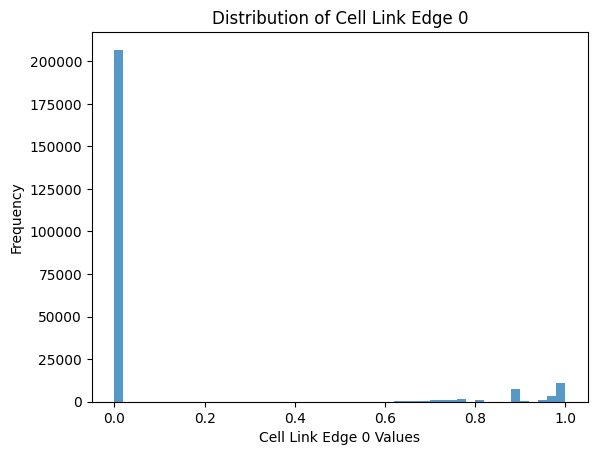

In [200]:
import matplotlib.pyplot as plt

# 假设 cell_link_edge 是一个 torch.Tensor 或 numpy 数组
cell_link_edge_0 = cell_link_edge[0].cpu().numpy()  # 如果是 torch.Tensor，先转换为 numpy

plt.hist(cell_link_edge_0, bins=50, alpha=0.75)
plt.xlabel('Cell Link Edge 0 Values')
plt.ylabel('Frequency')
plt.title('Distribution of Cell Link Edge 0')
plt.show()


In [57]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

data_np = cell_link_edge.cpu().numpy() * cell_link_activity.cpu().numpy() * edge_importance.cpu().numpy()

# PCA on data1_mt (numpy array)
pca1 = PCA(n_components=2)
pca_result1 = pca1.fit_transform(data_np)


select_cell_id_np = cell_type

Text(0.5, 1.0, 't-SNE for 1019-based scReGAT dataset 1')

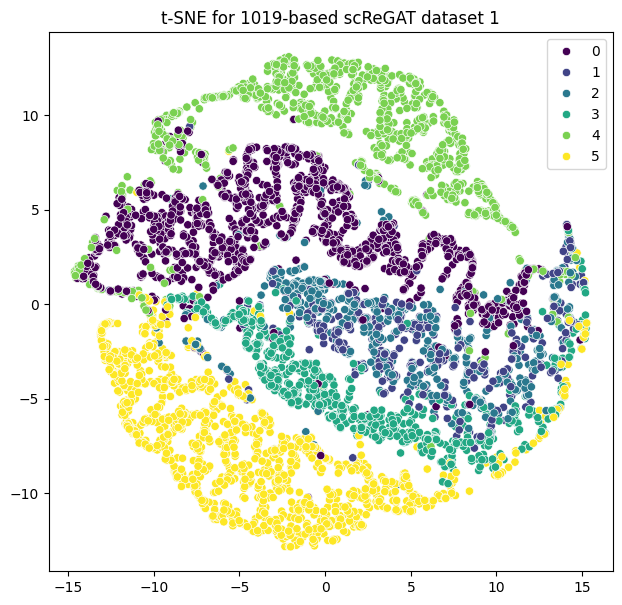

In [58]:
# Assuming select_cell_id is a torch tensor; convert it to numpy array if needed


# t-SNE on PCA results for data1_mt
tsne1 = TSNE(n_components=2, perplexity=25, n_iter=300)
tsne_result1 = tsne1.fit_transform(pca_result1)

# Plotting t-SNE results
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_result1[:,0], y=tsne_result1[:,1], hue=select_cell_id_np, palette='viridis')
plt.title('t-SNE for 1019-based scReGAT dataset 1')


In [175]:
a

NameError: name 'a' is not defined

In [49]:
cell_type_id

NameError: name 'cell_type_id' is not defined

In [84]:
cell_link_activity[0, :] == cell_link_enhancer[0, :]

tensor([True, True, True,  ..., True, True, True])

In [79]:
cell_link_enhancer

tensor([[0.0000, 0.9638, 0.9638,  ..., 0.0000, 0.0000, 0.0000],
        [1.4013, 0.5343, 0.7780,  ..., 0.0000, 0.2114, 0.2114],
        [1.1798, 0.9173, 1.3876,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.8711, 0.6557, 1.0483,  ..., 0.0000, 0.0000, 0.0000],
        [1.9924, 0.9008, 1.3669,  ..., 0.0000, 0.0000, 0.0000],
        [1.4599, 0.7428, 1.1643,  ..., 0.0000, 0.0000, 0.0000]])

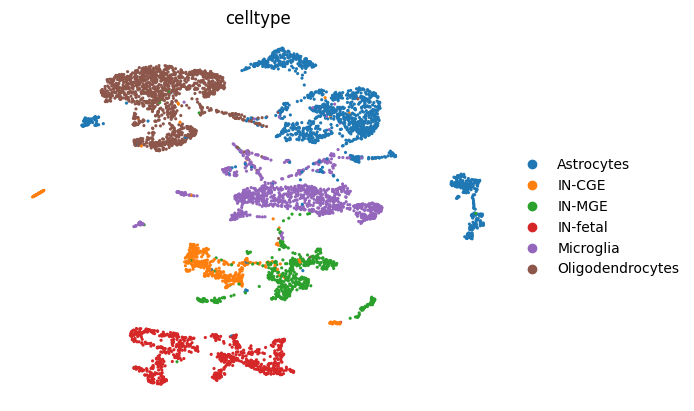

In [221]:
data_np = cell_link_atten.cpu().numpy()

import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

In [ ]:
# umap_plot = sc.pl.umap(adata, color=['celltype'], wspace=0.4, frameon=False, show=False)
# plt.savefig('./umap_plot.png')

# print("UMAP plot saved as 'umap_plot.png'")

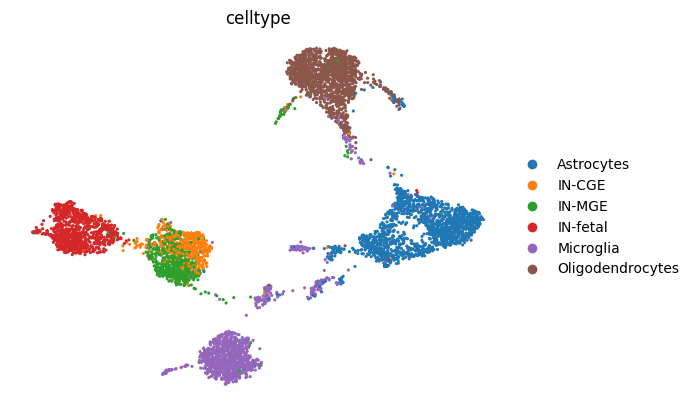

In [222]:
data_np = cell_link_activity.cpu().numpy()

import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

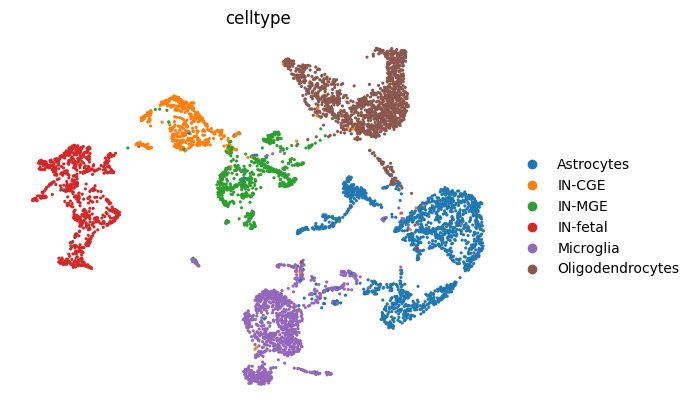

In [223]:
data_np = cell_link_enhancer.cpu().numpy() * cell_link_activity.cpu().numpy() 
import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

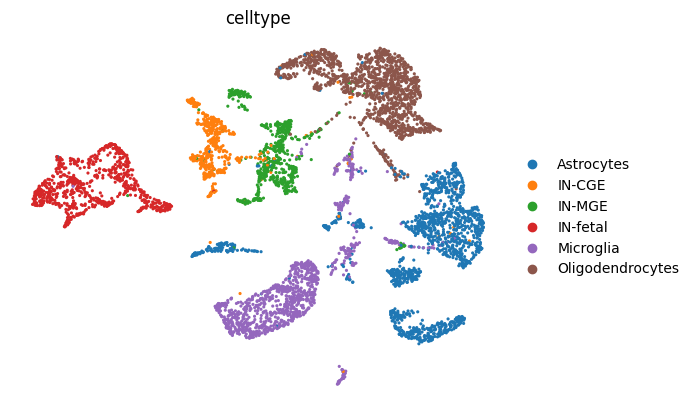

In [108]:
data_np = cell_link_activity.cpu().numpy()  * cell_link_atten.cpu().numpy()


import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

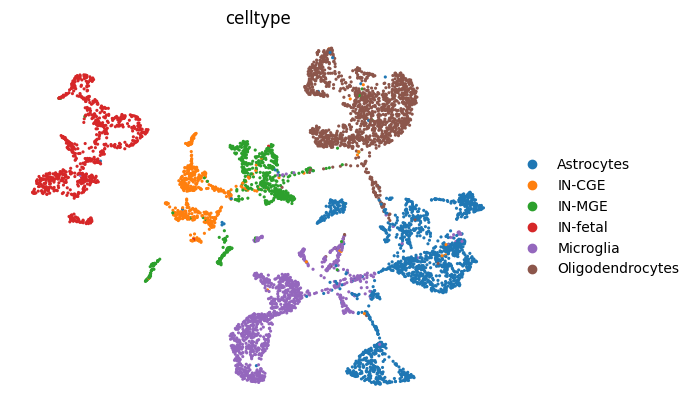

In [111]:
data_np = cell_link_atten.cpu().numpy()


import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

In [117]:
validate_df = pd.read_csv('../Cortex_Mulqueen/PLAC_seq_promoter_interactome_map.csv')
import pandas as pd
promoters = validate_df
related_gene = promoters['Gene Name']
genes = [peak for peak in dataset_atac.array_peak if not peak.startswith('chr')]
common_genes = related_gene[related_gene.isin(genes)]
promoters_filtered = promoters[promoters['Gene Name'].isin(common_genes)]
print(promoters_filtered)


import pandas as pd

split_interactions = promoters_filtered[
    (promoters_filtered['PU1_active_promoter'] == True) &
    (promoters_filtered['Olig2_active_promoter'] == False) &
    (promoters_filtered['NeuN_active_promoter'] == False) &
    (promoters_filtered['LHX2_active_promoter'] == False)
]


split_interactions = split_interactions.dropna(subset=['PU1_enhancer_interactions'])

expanded_interactions = []
expanded_genes = []
for gene, interactions in zip(split_interactions['Gene Name'], split_interactions['PU1_enhancer_interactions']):
    interactions = interactions.split(',')
    for interaction in interactions:
        expanded_genes.append(gene)
        expanded_interactions.append(interaction)
filtered_df = pd.DataFrame({'Gene Name': expanded_genes, 'Interaction': expanded_interactions})
filtered_df[['chrom', 'start', 'end']] = filtered_df['Interaction'].str.split('[:-]', expand=True)

gene_peaks = [peak for peak in dataset_atac.array_peak if not peak.startswith('chr')]  
enhancer_peaks = [peak for peak in dataset_atac.array_peak if  peak.startswith('chr')]  

import pandas as pd
import pybedtools

filtered_df['start'] = pd.to_numeric(filtered_df['start'], errors='coerce').astype('Int64')
filtered_df['end'] = pd.to_numeric(filtered_df['end'], errors='coerce').astype('Int64')

filtered_df = filtered_df[filtered_df['start'] < filtered_df['end']]

filtered_df = filtered_df.dropna(subset=['chrom', 'start', 'end'])

enhancer_peaks_formatted = [peak.replace('-', '\t').split('\t') for peak in enhancer_peaks]
df2 = pd.DataFrame(enhancer_peaks_formatted, columns=['chrom', 'start', 'end'])
df1 = filtered_df
df1['start'] = pd.to_numeric(df1['start'], errors='coerce').astype('Int64')
df1['end'] = pd.to_numeric(df1['end'], errors='coerce').astype('Int64')
df1 = df1[df1['start'] < df1['end']]

df2['start'] = pd.to_numeric(df2['start'], errors='coerce').astype('Int64')
df2['end'] = pd.to_numeric(df2['end'], errors='coerce').astype('Int64')
df2 = df2[df2['start'] < df2['end']]

# 将两个 DataFrame 转换为 BedTool 对象
bed1 = pybedtools.BedTool.from_dataframe(df1[['chrom', 'start', 'end']])
bed2 = pybedtools.BedTool.from_dataframe(df2[['chrom', 'start', 'end']])

# 找到 df2 中与 df1 相交的 peaks
intersection = bed2.intersect(bed1)

# 将交集结果转换为 DataFrame
intersection_df = intersection.to_dataframe(names=['chrom', 'start', 'end'])

# 将交集的 chrom, start, end 用 "-" 拼接成新的列
intersection_df['peak'] = intersection_df['chrom'] + '-' + intersection_df['start'].astype(str) + '-' + intersection_df['end'].astype(str)

# 返回拼接后的 peaks
result_peaks = intersection_df['peak'].tolist()

# 打印结果
print(result_peaks)


       PeakID   Chr      Start        End  \
14         15  chr1    1238517    1245441   
18         19  chr1    1333584    1336012   
35         36  chr1    1820222    1824079   
39         40  chr1    1981115    1982541   
40         41  chr1    2004489    2007767   
...       ...   ...        ...        ...   
15856   15857  chrX  153361439  153363929   
15863   15864  chrX  153664794  153667477   
15871   15872  chrX  153976701  153980209   
15890   15891  chrY   15589120   15592544   
15892   15893  chrY   16634026   16639249   

                                  Annotation  \
14        intron (NM_030649, intron 1 of 23)   
18                  promoter-TSS (NR_135154)   
35      intron (NM_001282538, intron 1 of 9)   
39                  promoter-TSS (NR_135509)   
40     intron (NM_001242874, intron 1 of 14)   
...                                      ...   
15856   intron (NM_001316337, intron 1 of 4)   
15863     intron (NM_001493, intron 1 of 10)   
15871      intron (NR_10411

In [118]:
result_peaks = np.unique(result_peaks)
import pandas as pd
import pybedtools

# 假设 filtered_df 和 result_peaks 已定义

# 将 filtered_df 转换为 BED 格式的字符串列表
filtered_bed_data = filtered_df[['chrom', 'start', 'end', 'Gene Name']].values
filtered_bed_entries = ['\t'.join(map(str, row)) for row in filtered_bed_data]

# 创建 filtered_df 的 pybedtools BedTool 对象
filtered_bedtool = pybedtools.BedTool('\n'.join(filtered_bed_entries), from_string=True)

# 将 result_peaks 转换为 BED 格式的字符串列表
result_peaks_parsed = []
for peak in result_peaks:
    chrom, start, end = peak.split('-')
    result_peaks_parsed.append([chrom, int(start), int(end)])

result_peaks_bed_entries = ['\t'.join(map(str, row)) for row in result_peaks_parsed]

# 创建 result_peaks 的 pybedtools BedTool 对象
result_peaks_bedtool = pybedtools.BedTool('\n'.join(result_peaks_bed_entries), from_string=True)

# 使用 pybedtools 的 intersect 函数查找重叠的区间
intersected = filtered_bedtool.intersect(result_peaks_bedtool, wa=True, wb=True)

# 将结果转换为 DataFrame
intersected_df = pd.read_csv(intersected.fn, sep='\t', header=None)
intersected_df.columns = ['chrom', 'start', 'end', 'Gene Name', 'peak_chrom', 'peak_start', 'peak_end']

intersected_df['peak_region'] = intersected_df['peak_chrom'] + '-' + intersected_df['peak_start'].astype(str) + '-' + intersected_df['peak_end'].astype(str)

# 删除不再需要的单独列（如果不需要保留）
intersected_df = intersected_df.drop(columns=['peak_chrom', 'peak_start', 'peak_end'])
intersected_df = intersected_df.drop_duplicates(subset=['Gene Name', 'peak_region'])


In [119]:
intersected_df

,chrom,start,end,Gene Name,peak_region
0,chr1,12185000,12230000,TNFRSF1B,chr1-12185398-12186057
1,chr1,12185000,12230000,TNFRSF1B,chr1-12194663-12194938
2,chr1,12185000,12230000,TNFRSF1B,chr1-12196407-12197011
3,chr1,12185000,12230000,TNFRSF1B,chr1-12198258-12198762
4,chr1,12185000,12230000,TNFRSF1B,chr1-12208339-12209598
...,...,...,...,...,...
9862,chr9,132645000,132810000,FNBP1,chr9-132799887-132800473
9863,chr9,132645000,132810000,FNBP1,chr9-132809375-132810000
9864,chr9,132645000,132810000,FNBP1,chr9-132809375-132810073
9902,chr9,132805000,132825000,FNBP1,chr9-132814345-132815301


In [127]:
validate_links = []
for t in intersected_df.values:
    validate_links.append(t[3] + '-' + t[4])

In [128]:
link_list = atten[0].cpu().numpy()
link_str = []
for t in range(len(link_list[0])):
    enhancer = dataset_atac.array_peak[link_list[0][t]]
    promoter = dataset_atac.array_peak[link_list[1][t]]
    
    # link_str.append('(\''+ promoter + '\','  + '\'' + enhancer + '\')')
    link_str.append(promoter + '-' + enhancer)
edge_index = []
for t in validate_links:
    try:
        edge_index.append(link_str.index(t))
    except:
        continue

array(['6032_GCTAAGTTCTTGAGCG-1', '5936_GGAACCTGTCATTAGG-1',
       '11_GAAAGCCAGCAGGTGG-1', ..., '6007_AAGGTCAAGCTTAACA-1',
       '5936_GGCAGGATCATTACAG-1', '5977_TGTGCTGAGCAATAGG-1'], dtype='<U25')

In [135]:
data_np = cell_link_atten

In [137]:
cell_link_atten.shape

torch.Size([5855, 237187])

array(['Oligodendrocytes', 'Oligodendrocytes', 'IN-fetal', ...,
       'Astrocytes', 'Astrocytes', 'Oligodendrocytes'], dtype=object)

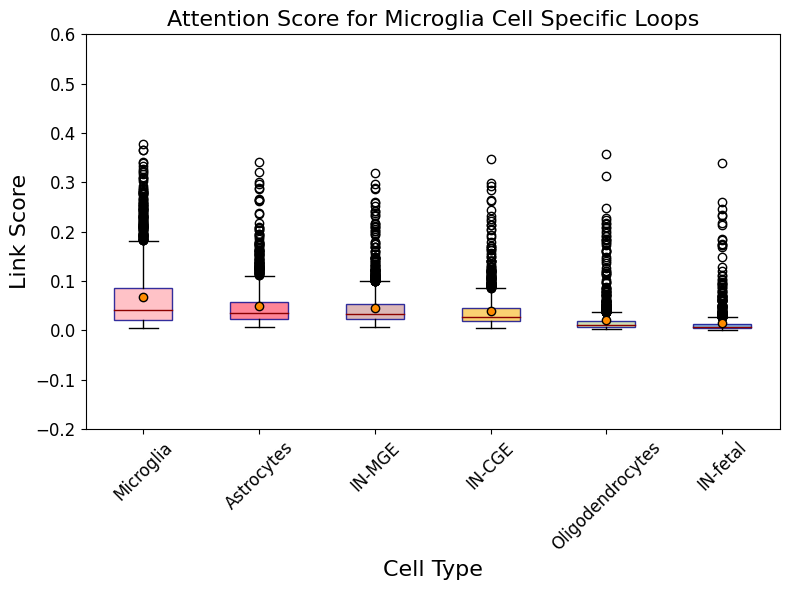

In [206]:
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming cell_link_mt and cell_type are defined
temp = cell_link_atten * cell_link_edge
cell_type = torch.tensor(cell_type, dtype=torch.int64)

# Select matching indices
temp = temp[:, edge_index]

# Move to CPU
temp_cpu = temp.cpu()
cell_type_cpu = dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)]['celltype'].values

# Normalize temp to 0-1 range
scaler = MinMaxScaler()
temp_normalized = torch.tensor(scaler.fit_transform(temp_cpu), dtype=torch.float32)

# Calculate mean for each cell type
unique_types = np.unique(cell_type_cpu)
means = [torch.mean(temp_normalized[cell_type_cpu == t, :], dim=0) for t in unique_types]

# Sort cell types by mean in descending order
mean_values = [torch.mean(temp_normalized[cell_type_cpu == t]) for t in unique_types]
sorted_indices = np.argsort(mean_values)[::-1]
sorted_types = unique_types[sorted_indices]
sorted_means = [means[i] for i in sorted_indices]

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
boxprops = dict(color="darkblue", facecolor="lightblue", alpha=0.8)
medianprops = dict(color="darkred")
meanpointprops = dict(marker="o", markeredgecolor="black", markerfacecolor="darkorange")
meanlineprops = dict(color="orange", linestyle="--", linewidth=1.5)

# Create boxplot
bp = ax.boxplot(sorted_means, patch_artist=True, boxprops=boxprops, medianprops=medianprops,
                meanprops=meanpointprops, showmeans=True)

# Custom colors
colors = ['#FFB3BA', '#FF677D', '#D4A5A5', '#F9C74F', '#C2D7A3', '#6C9FD0']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Set title and labels
ax.set_title('Attention Score for Microglia Cell Specific Loops', fontsize=16)
ax.set_xlabel('Cell Type', fontsize=16)
ax.set_ylabel('Link Score', fontsize=16)
ax.set_ylim(-0.2, 0.6)
ax.set_xticklabels([f'{t}' for t in sorted_types], fontsize=8)
ax.tick_params(axis='both', labelsize=12)

# Rotate x-ticks
plt.xticks(rotation=45)

# Set background color
fig.patch.set_facecolor('white')

# Save the figure
# fig.savefig('./fig/fig3_cell_typeNeur.png')

# Show plot
plt.tight_layout()
plt.show()


In [149]:
unique_types

array(['Astrocytes', 'IN-CGE', 'IN-MGE', 'IN-fetal', 'Microglia',
       'Oligodendrocytes'], dtype=object)

In [ ]:
cell_link_activity

In [ ]:
dataset_atac.adata.obs.loc[.index, :]

Text(0.5, 1.0, 't-SNE for 1019-based scReGAT dataset 1')

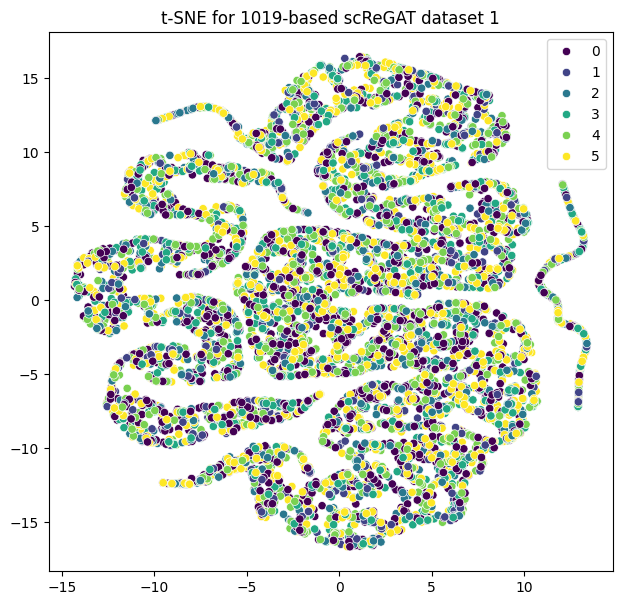

In [334]:
# Assuming select_cell_id is a torch tensor; convert it to numpy array if needed


# t-SNE on PCA results for data1_mt
tsne1 = TSNE(n_components=2, perplexity=25, n_iter=300)
tsne_result1 = tsne1.fit_transform(pca_result1)


# Plotting t-SNE results
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_result1[:,0], y=tsne_result1[:,1], hue=select_cell_id_np, palette='viridis')
plt.title('t-SNE for 1019-based scReGAT dataset 1')


Text(0.5, 1.0, 't-SNE for 1019-based scReGAT dataset 1')

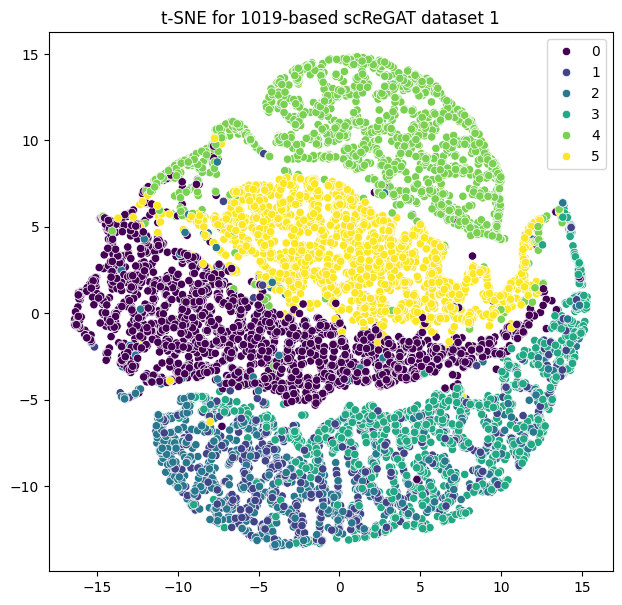

In [332]:
# Assuming select_cell_id is a torch tensor; convert it to numpy array if needed


# t-SNE on PCA results for data1_mt
tsne1 = TSNE(n_components=2, perplexity=25, n_iter=300)
tsne_result1 = tsne1.fit_transform(pca_result1)


# Plotting t-SNE results
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_result1[:,0], y=tsne_result1[:,1], hue=select_cell_id_np, palette='viridis')
plt.title('t-SNE for 1019-based scReGAT dataset 1')


In [2]:
import torch

In [3]:
temp = torch.load('./cell_link_edge.pt')

In [4]:
temp

tensor([[0.0000, 0.9992, 0.9992,  ..., 0.0000, 0.0000, 0.0000],
        [0.4998, 0.4998, 0.9996,  ..., 0.4998, 0.4998, 0.4998],
        [0.9992, 0.9992, 0.9992,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.9992, 0.9992, 0.9992,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9992, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9992, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [323]:
count_chr_start = sum(t.startswith('chr')==False for t in dataset_atac.array_peak)
print(count_chr_start)


4457


In [324]:
gene_anno

,0,1,2,3,4,5,6,7,8,gene_id,gene_name
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000290825.1""; gene_type ""lncRNA...",ENSG00000290825,DDX11L2
1,chr1,HAVANA,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000290825.1""; transcript_id ""EN...",ENSG00000290825,DDX11L2
2,chr1,HAVANA,exon,11869,12227,.,+,.,"gene_id ""ENSG00000290825.1""; transcript_id ""EN...",ENSG00000290825,DDX11L2
3,chr1,HAVANA,exon,12613,12721,.,+,.,"gene_id ""ENSG00000290825.1""; transcript_id ""EN...",ENSG00000290825,DDX11L2
4,chr1,HAVANA,exon,13221,14409,.,+,.,"gene_id ""ENSG00000290825.1""; transcript_id ""EN...",ENSG00000290825,DDX11L2
...,...,...,...,...,...,...,...,...,...,...,...
3467151,chrM,ENSEMBL,transcript,15888,15953,.,+,.,"gene_id ""ENSG00000210195.2""; transcript_id ""EN...",ENSG00000210195,MT-TT
3467152,chrM,ENSEMBL,exon,15888,15953,.,+,.,"gene_id ""ENSG00000210195.2""; transcript_id ""EN...",ENSG00000210195,MT-TT
3467153,chrM,ENSEMBL,gene,15956,16023,.,-,.,"gene_id ""ENSG00000210196.2""; gene_type ""Mt_tRN...",ENSG00000210196,MT-TP
3467154,chrM,ENSEMBL,transcript,15956,16023,.,-,.,"gene_id ""ENSG00000210196.2""; transcript_id ""EN...",ENSG00000210196,MT-TP


In [330]:
pd.DataFrame(dataset_atac.array_peak[:4457]).to_csv('./gene_node.csv', index=False)